# IMPORTING LIBRARIES

In [1]:
# import sklearn librarys
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import recall_score,precision_score,confusion_matrix, classification_report

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import  OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest,chi2

from matplotlib import pyplot as plt

from pandas_profiling import ProfileReport as profile

import pandas as pd
import numpy as np
import os
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.metrics import precision_recall_curve, roc_curve, auc

from xgboost import XGBRegressor 

from sklearn.compose import make_column_transformer

from sklearn.pipeline import make_pipeline

# READING DATASET

In [2]:
os.chdir("c:/Users/User/Documents/Github/housePricePrediction/")
df=pd.read_csv('house_train_data.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# DATA EXPLORATION - pandas profiling

In [3]:
# profile=df.profile_report(minimal=False,progress_bar=False, explorative=True, pool_size=0, samples=None,
#                                 missing_diagrams=None, duplicates=None);
# profile.to_file("output.html")

# HANDLING MISSING DATASET

In [4]:
print(df.isnull().mean().sort_values(ascending=False))

PoolQC           0.995205
MiscFeature      0.963014
Alley            0.937671
Fence            0.807534
FireplaceQu      0.472603
                   ...   
CentralAir       0.000000
SaleCondition    0.000000
Heating          0.000000
TotalBsmtSF      0.000000
Id               0.000000
Length: 81, dtype: float64


 Droping columns with more than 40% missing dataset

In [5]:
df=df.loc[: ,  df.isnull().mean()<0.40]

# Dropping the id columns because it has no predictive power
df.drop(columns=['Id'] ,axis=1, inplace=True)

print(df.isnull().mean().sort_values(ascending=False))

LotFrontage      0.177397
GarageType       0.055479
GarageYrBlt      0.055479
GarageCond       0.055479
GarageQual       0.055479
                   ...   
CentralAir       0.000000
HeatingQC        0.000000
SaleCondition    0.000000
TotalBsmtSF      0.000000
MSSubClass       0.000000
Length: 75, dtype: float64


In [6]:
numerical_columns=list(df.select_dtypes(include=['int64','float64']).columns)

In [7]:
imp_mean=SimpleImputer(missing_values=np.nan,strategy='mean')
imp_frequent=SimpleImputer(missing_values=np.nan,strategy="most_frequent")

transformed_columns= make_column_transformer  (
                                                ( imp_mean, list(df.select_dtypes(include=['int64','float64']).columns) ),
                                                ( imp_frequent,list(df.select_dtypes(exclude=['int64','float64']).columns) ),
                                                 remainder = 'passthrough'
                                              )

list_columns=list(df.select_dtypes(include=['int64','float64']).columns) + list(df.select_dtypes(exclude=['int64','float64']).columns)

df=pd.DataFrame(transformed_columns.fit_transform(df), columns=list_columns)

df[numerical_columns]=df.loc[:,numerical_columns].astype(float)
df.isnull().sum()

MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
                ..
GarageQual       0
GarageCond       0
PavedDrive       0
SaleType         0
SaleCondition    0
Length: 75, dtype: int64

In [8]:
df.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,2003.0,2003.0,196.0,706.0,0.0,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,20.0,80.0,9600.0,6.0,8.0,1976.0,1976.0,0.0,978.0,0.0,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,60.0,68.0,11250.0,7.0,5.0,2001.0,2002.0,162.0,486.0,0.0,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


# CORRELATION ANALYSIS

In [9]:
# Features and their correlation with the target variable
ans=df.iloc[:,:].corr()['SalePrice'].abs()     # using the absolute values
ans.sort_values(ascending=False).head(15)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.475241
GarageYrBlt     0.470177
Fireplaces      0.466929
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64

In [10]:
ans=df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()
ans.head(48)

SalePrice     SalePrice       1.000000
GarageCars    GarageArea      0.882475
TotRmsAbvGrd  GrLivArea       0.825489
TotalBsmtSF   1stFlrSF        0.819530
SalePrice     OverallQual     0.790982
YearBuilt     GarageYrBlt     0.780555
SalePrice     GrLivArea       0.708624
2ndFlrSF      GrLivArea       0.687501
TotRmsAbvGrd  BedroomAbvGr    0.676620
BsmtFullBath  BsmtFinSF1      0.649212
GarageCars    SalePrice       0.640409
GrLivArea     FullBath        0.630012
SalePrice     GarageArea      0.623431
GarageYrBlt   YearRemodAdd    0.618130
2ndFlrSF      TotRmsAbvGrd    0.616423
TotalBsmtSF   SalePrice       0.613581
HalfBath      2ndFlrSF        0.609707
SalePrice     1stFlrSF        0.605852
OverallQual   GarageCars      0.600671
              GrLivArea       0.593007
YearRemodAdd  YearBuilt       0.592855
YearBuilt     OverallQual     0.572323
1stFlrSF      GrLivArea       0.566024
GarageArea    OverallQual     0.562022
FullBath      SalePrice       0.560664
TotRmsAbvGrd  FullBath   

Dropping features with correlation >=60%

In [11]:
# GrLivArea was left out because not all houses were story buildings
df.drop(columns=['GarageArea','GarageYrBlt','TotalBsmtSF','2ndFlrSF','BedroomAbvGr','BsmtFinSF1',
                'FullBath','HalfBath'], inplace=True)

# TRANSFORMING FEATURES - dates

In [12]:
df['YearRemodAdd']=2020-df['YearRemodAdd']
df['YearBuilt']=2020-df['YearBuilt']
df.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,60.0,65.0,8450.0,7.0,5.0,17.0,17.0,196.0,0.0,150.0,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,20.0,80.0,9600.0,6.0,8.0,44.0,44.0,0.0,0.0,284.0,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,60.0,68.0,11250.0,7.0,5.0,19.0,18.0,162.0,0.0,434.0,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


# SPLITTING DATA INTO TARGET VARIABLE AND FEATURE SETS

In [13]:
y=df.loc[: , ['SalePrice']]
X=df.drop(columns=['SalePrice'])

In [14]:
X_CAT=X.select_dtypes(exclude=['int64','float64'])
X_NUM=X.select_dtypes(include=['int64','float64'])

In [15]:
scaler=MinMaxScaler()
ohe=OneHotEncoder(handle_unknown='error',sparse=False, dtype='float32' , drop='first')
X_CAT_TRANSFORM=pd.DataFrame(ohe.fit_transform(X_CAT))
X_CAT_TRANSFORM.columns=ohe.get_feature_names(X_CAT.columns)

X_NUM_TRANSFORM_SCALED=pd.DataFrame(scaler.fit_transform(X_NUM),columns=X_NUM.columns)

#  concatenating to create the feature set
X=pd.concat(
           [X_NUM_TRANSFORM_SCALED.reset_index(drop=True), 
            X_CAT_TRANSFORM.reset_index(drop=True)],
            axis=1
           )

In [16]:
X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.235294,0.150685,0.033420,0.666667,0.500,0.050725,0.116667,0.12250,0.0,0.064212,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,0.202055,0.038795,0.555556,0.875,0.246377,0.566667,0.00000,0.0,0.121575,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.235294,0.160959,0.046507,0.666667,0.500,0.065217,0.133333,0.10125,0.0,0.185788,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.294118,0.133562,0.038561,0.666667,0.500,0.688406,0.666667,0.00000,0.0,0.231164,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.235294,0.215753,0.060576,0.777778,0.500,0.072464,0.166667,0.21875,0.0,0.209760,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# SHAPE OF CLEANED DATASET TO BE USED FOR THE MODEL TRAINING

In [17]:
X.shape

(1460, 224)

# SPLITTING DATASET INTO TRAIN AND TEST SETS

In [18]:
# splitting Dataset into train set and test set ( ratio 80 : 20 )
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=15,test_size=0.20)

# FEATURE IMPORTANCE SELECTION

In [19]:
%%time
parameter_random_forest=dict({ 'max_features': ['auto'] ,
                               'random_state':[0] ,
                               'n_estimators':[20]
                             })

grid_random_forest_feat=GridSearchCV (   RandomForestRegressor(), 
                                         cv=2, 
                                         param_grid=parameter_random_forest,
                                         scoring='r2', 
                                         n_jobs=-1
                                      )


grid_random_forest_feat.fit(X_train,y_train)

y_predicted_random=grid_random_forest_feat.predict(X_train)            # using the gridsearchcv object for prediction

print('\n R2_score \t', grid_random_forest_feat.score(X_train , y_train),'\n')
pd.DataFrame(grid_random_forest_feat.cv_results_)                      # tabulating the outcome of gridsearchcv object

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)



 R2_score 	 0.9685293441718893 

Wall time: 4.76 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.417893,0.017138,0.016124,0.004024,auto,20,0,"{'max_features': 'auto', 'n_estimators': 20, '...",0.7188,0.803187,0.760994,0.042193,1


In [20]:
clf_rand_forest=grid_random_forest_feat.best_estimator_  # passing the instance of best search
feat_importance=pd.DataFrame(clf_rand_forest.feature_importances_).sort_values(by=0,ascending=False)


feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_train.columns,clf_rand_forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

ans=pd.DataFrame(feats,index=np.arange(len(feats)))
ans=(ans.T)
ans=ans.sort_values(by=0,ascending=False)
feat_importance=pd.DataFrame(ans.loc[:,0])
feat_importance.columns=['features']
print('List of features according to their importance in descending order')
feat_importance.head(18)

List of features according to their importance in descending order


,features
OverallQual,0.541367
GrLivArea,0.126809
1stFlrSF,0.101802
GarageCars,0.027479
LotArea,0.018954
MasVnrArea,0.015033
YearBuilt,0.014424
YearRemodAdd,0.013406
LotFrontage,0.009614
BsmtUnfSF,0.008581


# FEATURE IMPORTANCE RANKING  - GRAPHICAL REPRESENTATION

Following is the code snippet to plot the n most important features of a random forest model.

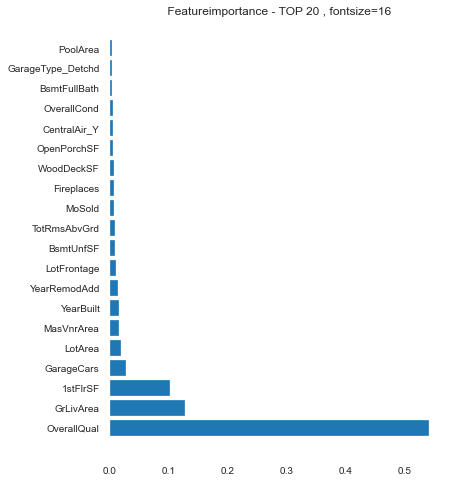

In [21]:
%matplotlib inline

feat_importance=feat_importance.iloc[0:20,:]
# X_train=X_train.loc[:,feat_importance.index]    #  X_train 30 most important features

# plot the 50 most important features 
plt.figure(figsize=(6,8))
plt.barh(y=feat_importance.index,width=feat_importance['features']);
plt.title(' Featureimportance - TOP 20 , fontsize=16')
plt.box(None)

# DISTRIBUTION OF THE TARGET VARIABLE - Price of house y

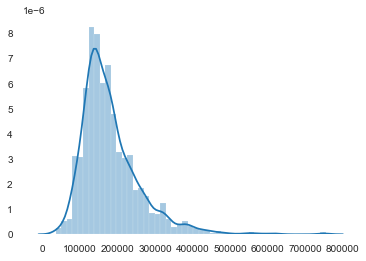

In [22]:
sns.distplot(y, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None)

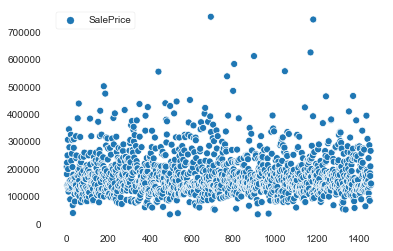

In [23]:
sns.scatterplot(data=y)

# COMPARING VARIOUS MACHINE LEARNING MODELS

# LASSO REGRESSION

In [24]:
%%time

parameter_Lasso=            dict({ 
                                            'alpha':np.arange(1,50),
                                            'random_state':[0],               
                                          })

grid_Lasso=GridSearchCV (    
                                 Lasso(), 
                                 cv=2, 
                                 param_grid=parameter_Lasso,
                                 scoring= 'r2',
                                 n_jobs= -1
                                )

grid_Lasso.fit(X_train,y_train)

print('R-squared score (training): {:.3f}'.format(grid_Lasso.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'.format(grid_Lasso.score(X_test, y_test)))

y_test_predicted_Lasso=grid_Lasso.predict(X_test)     # using the gridsearchcv object for prediction
print('Test RMSE \t:',np.sqrt(mean_squared_error( y_test, y_test_predicted_Lasso)))

# pd.DataFrame(grid_Lasso.cv_results_)       # tabulating the outcome of gridsearchcv object

R-squared score (training): 0.912
R-squared score (test): 0.873

Test RMSE 	: 28288.90929367308
Wall time: 6.61 s


# SUPPORT VECTOR REGRESSOR - SVR

In [25]:
%%time

parameter_SVR=            dict({ 
                                            'degree':[2,3,4],   
                                            'gamma': ['scale','auto'],
                                            'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
                                             'C' : [0.01,0.1,1,2,3,5,10]
                                          })

grid_SVR=GridSearchCV (    
                                 SVR(), 
                                 cv=2, 
                                 param_grid=parameter_SVR,
                                 scoring= 'r2',
                                 n_jobs= -1 
                                )

grid_SVR.fit(X_train,y_train)

print('R-squared score (training): {:.3f}'.format(grid_SVR.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'.format(grid_SVR.score(X_test, y_test)))

y_test_predicted_svr=grid_SVR.predict(X_test)     # using the gridsearchcv object for prediction
print('Test RMSE \t:',np.sqrt(mean_squared_error( y_test, y_test_predicted_svr)))

# pd.DataFrame(grid_SVR.cv_results_)       # tabulating the outcome of gridsearchcv object

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


R-squared score (training): 0.163
R-squared score (test): 0.190

Test RMSE 	: 71572.30295589732
Wall time: 44 s


# RANDOM FOREST REGRESSOR

In [26]:
%%time

parameter_random_forest=            dict({ 
                                            'n_estimators':[100,150,200,300,400,500],
                                            'criterion': ['mse'],
                                            'max_features': ['auto'],
                                            'bootstrap': [True],
                                            'oob_score': [True],
                                            'n_jobs' : [-1],
                                            'random_state':[0],
                                            'warm_start':[False],                
                                          })


grid_random_forest=GridSearchCV (    
                                 RandomForestRegressor(), 
                                 cv=2, 
                                 param_grid=parameter_random_forest,
                                 scoring= 'r2'
                                )

grid_random_forest.fit(X_train,y_train)

print('R-squared score (training): {:.3f}'.format(grid_random_forest.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'.format(grid_random_forest.score(X_test, y_test)))

y_test_predicted_forest=grid_random_forest.predict(X_test)
print('Test RMSE \t:',np.sqrt(mean_squared_error(y_test, y_test_predicted_forest)))

y_predicted=grid_random_forest.predict(X_train)     # using the gridsearchcv object for prediction
# pd.DataFrame(grid_random_forest.cv_results_)       # tabulating the outcome of gridsearchcv object

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was pa

R-squared score (training): 0.976
R-squared score (test): 0.884

Test RMSE 	: 27112.126890017636
Wall time: 44.5 s


In [27]:
predicted=pd.DataFrame(y_test_predicted_forest,columns=['predicted'])
actual=pd.DataFrame(y_test.astype('float64'))
com=pd.concat(
           [actual.reset_index(drop=True), 
            predicted.reset_index(drop=True)],
            axis=1
           )
com['Difference']=(com['SalePrice']-com['predicted'])

com.head(10)

,SalePrice,predicted,Difference
0,228500.0,260268.130,-31768.130
1,119500.0,125283.280,-5783.280
2,141000.0,137345.500,3654.500
3,109000.0,134245.350,-25245.350
4,233170.0,225601.955,7568.045
5,187000.0,184175.725,2824.275
6,174900.0,152048.685,22851.315
7,122500.0,134185.400,-11685.400
8,82500.0,183243.500,-100743.500
9,220000.0,228422.040,-8422.040


# ADA BOOST REGRESSOR

In [28]:
%%time

parameter_AdaBoost=            dict({ 
                                            'n_estimators':[100,200,300],
                                            'random_state':[0],    
                                            'learning_rate': [0.001,0.01,0.1],
                                            'loss': ['linear','square','exponential']
                                          })

grid_AdaBoost=GridSearchCV (    
                                 AdaBoostRegressor(), 
                                 cv=2, 
                                 param_grid=parameter_AdaBoost,
                                 scoring= 'r2',
                                 n_jobs= -1 
                                )

grid_AdaBoost.fit(X_train,y_train)

print('R-squared score (training): {:.3f}'.format(grid_AdaBoost.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'.format(grid_AdaBoost.score(X_test, y_test)))

y_test_predicted_AdaBoost=grid_AdaBoost.predict(X_test)      # using the gridsearchcv object for prediction
print('Test RMSE \t:',np.sqrt(mean_squared_error( y_test, y_test_predicted_AdaBoost)))

# pd.DataFrame(grid_AdaBoost.cv_results_)       # tabulating the outcome of gridsearchcv object

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


R-squared score (training): 0.872
R-squared score (test): 0.833

Test RMSE 	: 32521.245245209557
Wall time: 1min 10s


# GRADIENT BOOSTING REGRESSOR

In [29]:
%%time

parameter_grid_GBR=            dict({ 
                                            'n_estimators':[100,200,300],
                                            'criterion': ['friedman_mse'],
                                            'max_features': ['auto'],
                                            'random_state':[0],    
                                            'subsample': [0.85,1.0],
                                            'learning_rate': [0.001,0.01,0.1,]
                                          })


grid_GBR=GridSearchCV (    
                                 GradientBoostingRegressor(), 
                                 cv=2, 
                                 param_grid=parameter_grid_GBR,
                                 scoring= 'r2',
                                 n_jobs= -1
                                )

grid_GBR.fit(X_train,y_train)

print('R-squared score (training): {:.3f}'.format(grid_GBR.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'.format(grid_GBR.score(X_test, y_test)))

y_test_predicted_GBR=grid_GBR.predict(X_test)
print('Mean Square Error \t:',np.sqrt(mean_squared_error(y_test, y_test_predicted_GBR)))

# pd.DataFrame(grid_GBR.cv_results_)       # tabulating the outcome of gridsearchcv object

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


R-squared score (training): 0.982
R-squared score (test): 0.914

Mean Square Error 	: 23264.04997209329
Wall time: 22.6 s


# XGBOOSTING REGRESSOR

In [30]:
%%time
parameter_XGBoost=            dict({ 
                                    'objective':['reg:squarederror'],
                                    'max_depth':[3,4,5,8,10],
                                    'learning_rate' : [0.05,0.01,0.1],
                                    'n_estimators':[100,200,300],
                                    'gamma':[0,1,2,3],
                                    'subsample': [0.9],
                                    'colsample_bytree': [1],
                                    'reg_alpha' : [0,1,2,3,5,7,10],
                                    'scale_pos_weight':[1],
                                    'random_state':[0],
                                  })

grid_XGBoost=GridSearchCV (    
                                 XGBRegressor(), 
                                 cv=2, 
                                 param_grid=parameter_XGBoost,
                                 scoring= 'r2',
                                 n_jobs= -1 
                                )

grid_XGBoost.fit(X_train,y_train)

print('R-squared score (training): {:.3f}'.format(grid_XGBoost.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'.format(grid_XGBoost.score(X_test, y_test)))

y_test_predicted_XGBoost=grid_XGBoost.predict(X_test)     # using the gridsearchcv object for prediction
print('Test RMSE \t:',np.sqrt(mean_squared_error( y_test, y_test_predicted_XGBoost)))

df_XGBoost=pd.DataFrame(grid_XGBoost.cv_results_)       # tabulating the outcome of gridsearchcv object

R-squared score (training): 0.974
R-squared score (test): 0.917

Test RMSE 	: 22924.707055810806
Wall time: 41min 15s


In [31]:
ans=df_XGBoost.sort_values(by=['rank_test_score'])
ans.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_gamma,param_learning_rate,param_max_depth,param_n_estimators,param_objective,param_random_state,param_reg_alpha,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
962,2.534592,0.005263,0.029195,0.000994,1,3,0.05,3,300,reg:squarederror,0,3,1,0.9,"{'colsample_bytree': 1, 'gamma': 3, 'learning_...",0.731593,0.836558,0.784076,0.052483,1
332,3.640440,0.010100,0.039315,0.001018,1,1,0.05,3,300,reg:squarederror,0,3,1,0.9,"{'colsample_bytree': 1, 'gamma': 1, 'learning_...",0.731593,0.836558,0.784076,0.052483,1
17,3.450220,0.007097,0.039371,0.000941,1,0,0.05,3,300,reg:squarederror,0,3,1,0.9,"{'colsample_bytree': 1, 'gamma': 0, 'learning_...",0.731593,0.836558,0.784076,0.052483,1
647,2.496365,0.011030,0.026183,0.004022,1,2,0.05,3,300,reg:squarederror,0,3,1,0.9,"{'colsample_bytree': 1, 'gamma': 2, 'learning_...",0.731593,0.836558,0.784076,0.052483,1
333,3.129413,0.005287,0.040246,0.000156,1,1,0.05,3,300,reg:squarederror,0,5,1,0.9,"{'colsample_bytree': 1, 'gamma': 1, 'learning_...",0.731593,0.836558,0.784076,0.052483,5


Using the ideal parameter values to build the final XGBOOTED model

In [32]:
best_parameter=grid_XGBoost.best_params_
best_parameter

{'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 300,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 3,
 'scale_pos_weight': 1,
 'subsample': 0.9}

.

.

# BUILDING THE OPTIMISED XGBOOSTED MODEL

# Re-reading the entire dataset

In [33]:
# Re-reading the entire dataset for the to train the optimised model
os.chdir("c:/Users/User/Desktop/kaggle datasets/housing dataset/")
df=pd.read_csv('house_train_data.csv')

In [34]:
# Transforming the two date columns into years 
df['YearRemodAdd']=2020-df['YearRemodAdd']
df['YearBuilt']=2020-df['YearBuilt']

# Selecting the top 18 features according to their importance

In [35]:
df=df[['OverallQual','GrLivArea','1stFlrSF','GarageCars','LotArea','MasVnrArea','YearBuilt','YearRemodAdd','LotFrontage',
       'BsmtUnfSF','TotRmsAbvGrd','MoSold','Fireplaces','WoodDeckSF','OpenPorchSF','CentralAir','OverallCond','SalePrice']]

print(df.shape)
df.head(2)

(1460, 18)


,OverallQual,GrLivArea,1stFlrSF,GarageCars,LotArea,MasVnrArea,YearBuilt,YearRemodAdd,LotFrontage,BsmtUnfSF,TotRmsAbvGrd,MoSold,Fireplaces,WoodDeckSF,OpenPorchSF,CentralAir,OverallCond,SalePrice
0,7,1710,856,2,8450,196.0,17,17,65.0,150,8,2,0,0,61,Y,5,208500
1,6,1262,1262,2,9600,0.0,44,44,80.0,284,6,5,1,298,0,Y,8,181500


# Handling Missing Data

In [36]:
# Dropping the rows with missing values for MasVnrArea
df=df.loc[df['MasVnrArea'].notnull(), : ]

# converting LotFrontage to a numeric dtypes
df['LotFrontage']=pd.to_numeric(df['LotFrontage'], errors='coerce')
print(df.isnull().sum())

print('\n',df.dtypes)

OverallQual       0
GrLivArea         0
1stFlrSF          0
GarageCars        0
LotArea           0
MasVnrArea        0
YearBuilt         0
YearRemodAdd      0
LotFrontage     257
BsmtUnfSF         0
TotRmsAbvGrd      0
MoSold            0
Fireplaces        0
WoodDeckSF        0
OpenPorchSF       0
CentralAir        0
OverallCond       0
SalePrice         0
dtype: int64

 OverallQual       int64
GrLivArea         int64
1stFlrSF          int64
GarageCars        int64
LotArea           int64
MasVnrArea      float64
YearBuilt         int64
YearRemodAdd      int64
LotFrontage     float64
BsmtUnfSF         int64
TotRmsAbvGrd      int64
MoSold            int64
Fireplaces        int64
WoodDeckSF        int64
OpenPorchSF       int64
CentralAir       object
OverallCond       int64
SalePrice         int64
dtype: object


In [37]:
df['LotFrontage']=df['LotFrontage'].replace('.','')
df['LotFrontage'].fillna(df['LotFrontage'].mean(),inplace=True)
df.isnull().sum()

OverallQual     0
GrLivArea       0
1stFlrSF        0
GarageCars      0
LotArea         0
MasVnrArea      0
YearBuilt       0
YearRemodAdd    0
LotFrontage     0
BsmtUnfSF       0
TotRmsAbvGrd    0
MoSold          0
Fireplaces      0
WoodDeckSF      0
OpenPorchSF     0
CentralAir      0
OverallCond     0
SalePrice       0
dtype: int64

# Separating the target variable from the independent variable

In [38]:
y=df['SalePrice']
X=df.drop(labels=['SalePrice'], axis=1)

# Splitting Dataset into train set and test set ( ratio 95 : 5 )

In [39]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y, random_state=15,test_size=5)

# Transforming the Dataset 

In [40]:
columns_tran=['OverallQual', 'GrLivArea', '1stFlrSF', 'GarageCars', 'LotArea',
                                               'MasVnrArea', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', 'BsmtUnfSF',
                                               'TotRmsAbvGrd', 'MoSold', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF','OverallCond','CentralAir']

transformed_columns= make_column_transformer (
                                               (MinMaxScaler(), 
                                               ['OverallQual', 'GrLivArea', '1stFlrSF', 'GarageCars', 'LotArea',
                                               'MasVnrArea', 'YearBuilt', 'YearRemodAdd', 'LotFrontage', 'BsmtUnfSF',
                                               'TotRmsAbvGrd', 'MoSold', 'Fireplaces', 'WoodDeckSF', 'OpenPorchSF','OverallCond'] ),
                                                
                                                (OneHotEncoder(handle_unknown='error',sparse=False, dtype='float32' , drop='first'),['CentralAir']),
                                                remainder = 'passthrough'
                                              )

# transformer=transformed_columns.fit_transform(X_train)

# X_train=pd.DataFrame(transformer,columns=columns_tran)
# X_train.head()

# THE OPTIMISED XGBOOSTED MODEL

In [41]:
XGBRegressor=XGBRegressor (
                             colsample_bytree= 1,
                             gamma= 0,
                             learning_rate= 0.05,
                             max_depth= 3,
                             n_estimators= 300,
                             objective='reg:squarederror',
                             random_state=0,
                             reg_alpha= 3,
                             scale_pos_weight= 1,
                             subsample=0.9
                          )

# THE PIPELINE

In [42]:
pipe=make_pipeline(transformed_columns, XGBRegressor)
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['OverallQual', 'GrLivArea',
                                                   '1stFlrSF', 'GarageCars',
                                                   'LotArea', 'MasVnrArea',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'LotFrontage', 'BsmtUnfSF',
                                                   'TotRmsAbvGrd', 'MoSold',
                                                   'Fireplaces', 'WoodDeckSF',
                                                   'OpenPorchSF',
                                                   'OverallCond']),
                                                 ('onehotencoder',
                      

# TEST ON THE OPTIMISED MODEL

In [43]:
print('R-squared score (training): {:.3f}'.format(pipe.score(X_train, y_train)))
print('R-squared score (test): {:.3f}\n'.format(pipe.score(X_test, y_test)))

y_predicted_train=pipe.predict(X_train)
print('Train RMSE \t:',np.sqrt(mean_squared_error( y_train, y_predicted_train)))

y_test_predicted=pipe.predict(X_test)                           
print('Test RMSE \t:',np.sqrt(mean_squared_error( y_test, y_test_predicted)))

R-squared score (training): 0.960
R-squared score (test): 0.935

Train RMSE 	: 15835.088790405514
Test RMSE 	: 29983.220915659578


# SAVING THE MODEL - pickling

In [44]:
import pickle
import os

os.chdir('c://Users/user/.spyder-py3/templates/pickle/')

file=open('model_housePricePrediction_xgboost2020.pkl','wb')
pickle.dump(pipe,file)
file.close()

# The Test Dataset

In [45]:
X_test['House_Price']=y_test
df=X_test
df

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,OverallQual,GrLivArea,1stFlrSF,GarageCars,LotArea,MasVnrArea,YearBuilt,YearRemodAdd,LotFrontage,BsmtUnfSF,TotRmsAbvGrd,MoSold,Fireplaces,WoodDeckSF,OpenPorchSF,CentralAir,OverallCond,House_Price
1086,4,1092,546,1,1974,0.0,47,47,70.030126,212,6,5,0,120,96,Y,5,83500
1136,6,1252,1032,1,9600,0.0,70,70,80.000000,752,6,4,0,0,0,Y,5,119000
336,9,1922,1922,3,14157,200.0,15,14,86.000000,673,8,7,1,178,51,Y,5,377426
211,6,1212,1212,2,10420,0.0,11,11,83.000000,1176,6,3,0,100,22,Y,5,186000
377,8,2466,1580,2,11143,0.0,16,15,102.000000,1580,8,12,1,159,214,Y,5,340000
